In [4]:
import sys
import os
import numpy as np

%pylab inline
import pylab as pl

# Make plots prettyful
pl.style.use('fivethirtyeight')

# read in pandas and geopandas for data processing
import pandas as pd
import geopandas as geo
import itertools

import networkx as nx #library supporting networks
import scipy.stats as stat
import statsmodels.formula.api as smf

#Coding: utf-8
from __future__ import unicode_literals
import json
import urllib2

from geopandas.tools import sjoin

Populating the interactive namespace from numpy and matplotlib


In [8]:
workfolder = os.getenv('Projects') + '/Uber_market'
os.chdir(workfolder)

# I - Subset 2014-2015 Data
## 1. Load and created datetime index

In [2]:
uber = {}
uber['2014'] = pd.DataFrame(columns=['Date/Time', 'Lat', 'Lon', 'Base'])

for month in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    df = pd.read_csv('Data/uber-tlc-foil-response/uber-trip-data/uber-raw-data-{}14.csv'
                     .format(month), parse_dates=[0])
    uber['2014'] = uber['2014'].append(df)
    
uber['2014'] = uber['2014'].rename(columns={'Date/Time': 'pickup_datetime'})
uber['2014'].index = uber['2014'].pickup_datetime

uber['2015'] = (pd.read_csv('Data/uber-tlc-foil-response/uber-trip-data/uber-raw-data-janjune-15.csv', parse_dates=[1])
                .rename(columns={'Pickup_date': 'pickup_datetime','locationID': 'location_id'}))
uber['2015'].index = uber['2015'].pickup_datetime

## 2. Subset "weekday peak" uber trips 

In [ ]:
uber_wpeak = {}
for year, df in uber.items():
    df = df.between_time('06:30', '09:30')    
    df['weekday'] = df.index.weekday
    df = df.loc[df.weekday < 5]
    uber_wpeak[year] = df

for year, df in uber_wpeak.items():
    print year, df.shape, float(df.shape[0])*100/uber[year].shape[0]

## 3. Plot share of uber trips used in each month

In [127]:
#Count the share of uber trips happening at peak hour, per week
a = {}
for year in ['2014', '2015']:
    a[year] = (uber_wpeak[year].groupby([uber_wpeak[year].index.month, 
                                        uber_wpeak[year].index.week]).count()['weekday']*100./
               uber[year].groupby([uber[year].index.month, uber[year].index.week]).count()['pickup_datetime'])

#Drop null values, and extreme values (due to some specific events)
b = {}
b['2014'] = a['2014'].loc[(a['2014'].isnull() == False) & (a['2014'].astype(str).str[:5] != '13.52') & 
                          (a['2014'] < 13.54)]
b['2015'] =  a['2015'].loc[(a['2015'].isnull() == False) & (a['2015'] > 4) & (a['2015'] < 14)]

In [59]:
#Build a time series of share of uber trips happening at peak hour, per week
start = pd.datetime(2014,4,1)
end = pd.datetime(2015,6,30)
rng = pd.bdate_range(start, end, freq='W')

ratio = ratio = list(b['2014']) + [np.nan]*(len(rng)-len(b['2014'])-len(b['2015'])) + list(b['2015'])

ts = pd.DataFrame(index=rng)
ts['Ratio'] = ratio
ts.to_csv('Data/Output/ratio_ts.csv')

NameError: name 'b' is not defined

In [61]:
#Reimport
ts = pd.read_csv('Data/Output/ratio_ts.csv')
ts.index = pd.to_datetime(ts['Unnamed: 0'])

In [34]:
#Add the ratio for TLC
#From TLC reports, we know that ratio of morning peak TLC trips is around 9.6
#I just add the same seasonality variation as Uber
ts['Ratio_tlc'] = ts.Ratio + (9.6 - ts.Ratio)/2

#Correct with detailed averages by month in 2014
ts.loc[(ts.index.month == 4) & (ts.index.year == 2014), 'Ratio_tlc'] = 10.08 + np.random.normal(0,0.5, 4)
ts.loc[(ts.index.month == 5) & (ts.index.year == 2014), 'Ratio_tlc'] = 9.64 + np.random.normal(0,0.5, 4)
ts.loc[(ts.index.month == 7) & (ts.index.year == 2014), 'Ratio_tlc'] = 9.94 + np.random.normal(0,0.5, 4)
ts.loc[(ts.index.month == 9) & (ts.index.year == 2014), 'Ratio_tlc'] = 9.92 + np.random.normal(0,0.5, 4)

#Correct with detailed averages by month in 2014
ts.loc[(ts.index.month == 1) & (ts.index.year == 2015),'Ratio_tlc'] = 9.56 + np.random.normal(0,0.5, 4)
ts.loc[(ts.index.month == 3) & (ts.index.year == 2015),'Ratio_tlc'] = 10.09 + np.random.normal(0,0.5, 5)
ts.loc[(ts.index.month == 5) & (ts.index.year == 2015),'Ratio_tlc'] = 9.35 + np.random.normal(0,0.5, 5)

/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()
/Users/arnoamabile/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()


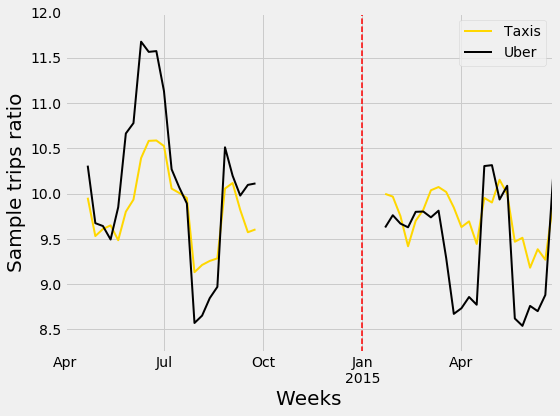

In [35]:
#Plot the share of peak morning trips by week, for TLC and Uber
fig = pl.figure(figsize=(8,6))
ax = fig.add_subplot(111)

pd.rolling_mean(ts.Ratio_tlc,4).plot(linewidth=2.0, color='gold', label='Taxis')
pd.rolling_mean(ts.Ratio, 4).plot(linewidth=2.0, color='black', label='Uber')

pl.xlabel('Weeks', fontsize=20)
pl.ylabel('Sample trips ratio', fontsize=20)
ax.set_ylim(8.25,12)

ymin, ymax = ax.get_ylim()
ax.vlines(x='2015-01-01', ymin=ymin, ymax=ymax, color='r', linewidth=1.5, linestyle='--')

#ax.set_title('Share of trips happening at peak morning hour, by week')

pl.legend()
pl.tight_layout(h_pad=5.0)
pl.savefig('Figures/ratio.pdf')

In [63]:
#Save peak trip data
for year, df in uber_wpeak.items():
    df.to_csv('Data/Output/uber_{}_wpeak.csv'.format(year))

# II -  Aggregate the Uber trips geographically

In [36]:
#Load peak data
uber_wpeak = {}
uber_wpeak['2015'] = pd.read_csv('Data/Output/uber_2015_wpeak.csv', parse_dates=[2])
uber_wpeak['2015'].index = uber_wpeak['2015'].pickup_datetime

## 1. Uber 2015 at NTA level

In [65]:
#Load NTA & taxi zones
zone_nta = pd.read_csv('Data/Non538_Input/taxi-zone-lookup-with-ntacode.csv')
uber_aggr = {}

#Aggregate by NTA zone
df = uber_wpeak['2015'].groupby([uber_wpeak['2015'].index.month, 'location_id']).pickup_datetime.count()
uber_aggr['2015'] = df.reset_index().rename(columns={'level_0': 'month', 'pickup_datetime':'tripcount'})
uber_aggr['2015'] = (uber_aggr['2015'].merge(zone_nta, on='location_id', how='left')
                     .rename(columns={'ntacode': 'NTACode'}))

## 2. Uber 2014 at Census Tract level

In [66]:
#Joined outside
uber14_ct = pd.read_csv('Data/Non538_Input/uber14_ct.csv', parse_dates=[1])

for var in ['COUNTYFP', 'GEOID', 'STATEFP', 'TRACTCE']:
    uber14_ct.loc[uber14_ct['{}'.format(var)].isnull() == True, 
                  '{}'.format(var)] = uber14_ct.loc[uber14_ct['{}'.format(var)].isnull() == True, '{}_2'.format(var)]

#Aggregate at the census tract level
df = uber14_ct.groupby([uber14_ct.pickup_datetime.dt.month, 'GEOID']).Base.count()
uber_aggr['2014'] = df.reset_index().rename(columns={'pickup_datetime': 'month', 'Base': 'tripcount'})

### 2b. Add NTA & Airport id on Uber 2014

In [68]:
#Add NTA based on Census Tract location
ct_nta = pd.read_csv('Data/Non538_Input/ct_cd_corresp2.csv')
uber_aggr['2014'] = uber_aggr['2014'].merge(ct_nta[['NTACode', 'tract_fips_10']], left_on='GEOID', 
                                            right_on='tract_fips_10', how='left').drop('tract_fips_10',1)

#Add airport id
airports = {36081033100: 'QNLGA', 36081071600: 'QNJFK', 34013980200: 'NJEWR', 34039039800: 'NJEWR'}
uber_aggr['2014'].loc[uber_aggr['2014'].GEOID.isin(airports.keys()), 'NTACode'] = \
uber_aggr['2014'].loc[uber_aggr['2014'].GEOID.isin(airports.keys()), 'GEOID'].map(airports.get)

uber_aggr['2014'].loc[(uber_aggr['2014'].NTACode.isnull() == True)].GEOID.astype(str).str[:2].value_counts()

34    1374
36    1007
Name: GEOID, dtype: int64

## 3. Add total month trips on Uber 2014-2015

In [69]:
for year, df in uber_aggr.items():
    for mth in df.month:
        uber_aggr[year].loc[uber_aggr[year].month == mth, 'month_count'] = df.loc[df.month == mth].tripcount.sum()

In [70]:
for year, df in uber_aggr.items():
    df.to_csv('Data/Output/uber_aggr_{}.csv'.format(year))

**There are trips with no census tract, there are all in NJ near transport hubs: not homes**

# III - Share of uber trips starting outside Manhattan

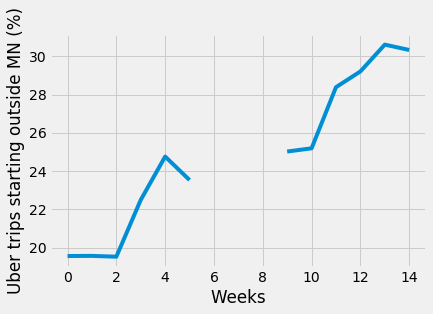

In [71]:
mn = {}
for year, df in uber_aggr.items():
    mn[year] = (100.*df.loc[df.NTACode.str[:2] != 'MN'].groupby('month').tripcount.sum()/
                df.groupby('month').tripcount.sum())
    
pl.plot(list(mn['2014']) + [np.nan]*3 + list(mn['2015']))

pl.ylabel('Uber trips starting outside MN (%)')
pl.xlabel('Weeks');

In [72]:
#Share of uber trips from New Jersey
print "NJ trip share: {0:.2f}%".format(uber_aggr['2014']
                                     .loc[uber_aggr['2014'].GEOID.astype(str).str[:2] == '34']
                                     .tripcount.sum()*100./uber_aggr['2014'].tripcount.sum())

NJ trip share: 1.30%


In [73]:
#Check number of unique NTAs as origins of trips
print "Nb. of unique NTAs: {}".format(uber_aggr['2015'].NTACode.nunique())

Nb. of unique NTAs: 190
